# TS 2025 - Assignment 2

Before you begin, set the assignment seed to the student id of one of your team members in the cell below.
To choose the data for this set the assignment seed to the student id of one of the team members. The
cell is prefilled with an **example** student id, so make sure to change it and **run the cell** before proceeding
further.

In [11]:
# NB!: change this to the student id of one of your team members

assignment_seed = "6EB8000033"

## Presentation

Do not create powerpoint slides or similar presentations for this assignment. The only submission should be
this Jupyter notebook with the completed code and results.

For the presentation of your results please **only include**:

    - Plots
    - Numeric results
    - Tables of model parameters and summaries

**Do not include**:

    - Text in comments or markdown cells
    - Custom functions in the code
    - if-then-else statements or similar control flow structures
    - Loops (for, while, etc.)
    - Any other code that is not directly related to the assignment tasks
  
**Explanations**

For the presentation you should be able to explain all the steps and be able to answer questions about

- Why you use a specific model/test/plot
- What is shown in the plots and numeric results
- How to interpret the results
  
## Tasks

1. Run the following cell to load your data. It will be stored in the pandas Series `dt`. All time series
are stock prices from the SOFIX index. The data that you should use for the model selection is stored in the
series `train`. The data for testing the forecasts is stored in the series `test`.

2. Adjust the labels and titles of the plots to reflect the stock you are analyzing
3. Your task is to select an ARIMA model for the stock price.
   - Choose the order of differencing based on the ACF/PACF plots and unit root tests (ADF, KPSS)
   - Choose the AR and MA orders based on the ACF/PACF plots and information criteria (AIC, BIC)
4. After selecting the ARIMA model, analyze the residuals
   - Plot the residuals and their ACF/PACF
   - Perform the Ljung-Box test on the residuals
   - Plot the histogram and QQ-plot of the residuals
5. Analyze the volatility of the residuals using an appropriate plot
6. Fit several ARCH/GARCH models to the residuals
   - Plot the conditional volatility
   - Analyze the standardized residuals of the GARCH model (plots, Ljung-Box test, histogram, QQ-plot)
   - Test whether negative and positive shocks have different effects on volatility
  
7. Forecast the stock prices for the test period using the ARIMA model in two ways:
   - By manually differencing the data before fitting the ARIMA model
   - By using the integrated ARIMA model directly
   - Compare the forecasts from both methods and explain the differences, explain the meaning of an
     intercept in the ARIMA model with differenced data
   - Plot the forecasts along with the actual values
   - Compute the RMSE of the forecasts

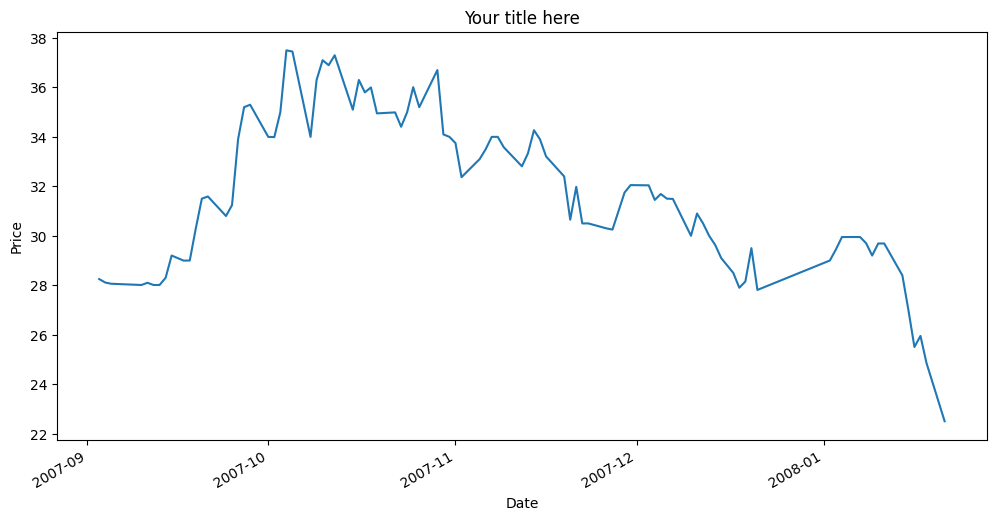

In [12]:
# Import libraries

%pip install arch

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from scipy import stats
import numpy as np

np.random.seed(int(re.sub(r"\D", "", assignment_seed)))

stocks = pd.read_excel("https://github.com/febse/data/raw/refs/heads/main/ts/SOFIX-Stocks.xlsx", usecols="A:Q").set_index("Date")

dt = stocks[np.random.choice(stocks.columns)]

# Split the data into training and test sets

train_size = int(len(dt) * 0.85)
train, test = dt[:train_size], dt[train_size:]

# Plot the training data

train.plot(title="Stock Price", figsize=(12, 6))

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Your title here")
plt.show()

/tmp/ipython-input-43147357.py:1: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = 100 * dt.pct_change().dropna()


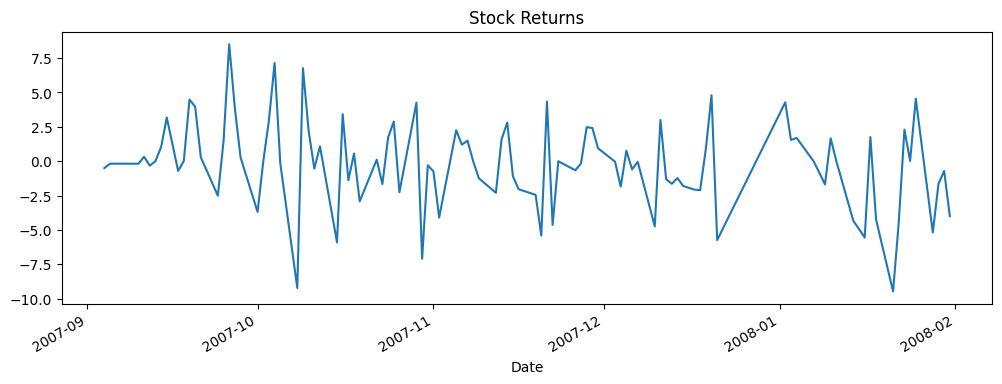

In [13]:
returns = 100 * dt.pct_change().dropna()
train_returns = returns[:train_size]
test_returns = returns[train_size:]

returns.plot(title="Stock Returns", figsize=(12, 4))
plt.show()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

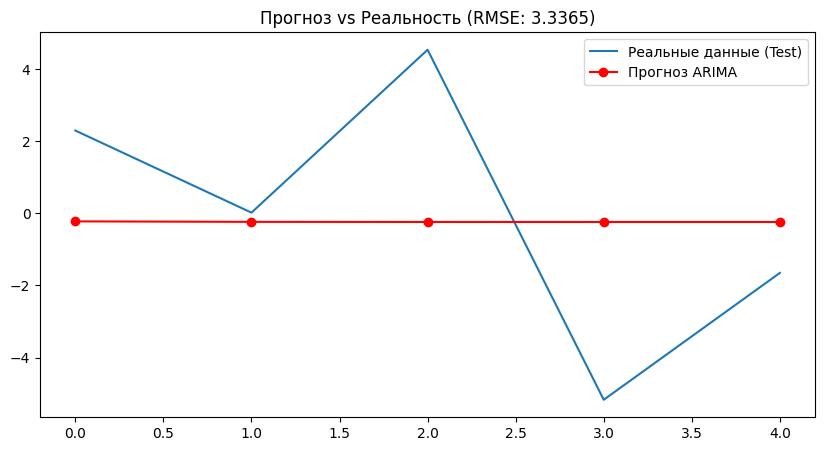

                               SARIMAX Results                                
Dep. Variable:                   TOPL   No. Observations:                   94
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -243.315
Date:                Wed, 14 Jan 2026   AIC                            494.631
Time:                        17:40:26   BIC                            504.804
Sample:                             0   HQIC                           498.740
                                 - 94                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2373      0.337     -0.705      0.481      -0.898       0.423
ar.L1          0.2378     33.343      0.007      0.994     -65.114      65.590
ma.L1         -0.2405     33.336     -0.007      0.9

In [14]:
# 1. Строим модель ARIMA для доходностей
model_arima = ARIMA(train_returns, order=(1, 0, 1))
results_arima = model_arima.fit()

# 2. Делаем прогноз на 5 шагов вперед (как в тестовой выборке)
forecast_steps = 5
forecast_res = results_arima.get_forecast(steps=forecast_steps)
forecast_values = forecast_res.predicted_mean

# 3. Считаем RMSE (требование учителя)
from sklearn.metrics import mean_squared_error
actual_values = test_returns[:forecast_steps]
rmse = np.sqrt(mean_squared_error(actual_values, forecast_values))

# 4. Строим график (требование учителя)
plt.figure(figsize=(10, 5))
plt.plot(actual_values.values, label='Реальные данные (Test)')
plt.plot(forecast_values.values, label='Прогноз ARIMA', color='red', marker='o')
plt.title(f"Прогноз vs Реальность (RMSE: {rmse:.4f})")
plt.legend()
plt.show()

print(results_arima.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   TOPL   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -240.125
Distribution:                  Normal   AIC:                           488.249
Method:            Maximum Likelihood   BIC:                           498.423
                                        No. Observations:                   94
Date:                Wed, Jan 14 2026   Df Residuals:                       93
Time:                        17:43:05   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.2407      0.322     -0.748      0.454 [ -0.871,  0.39

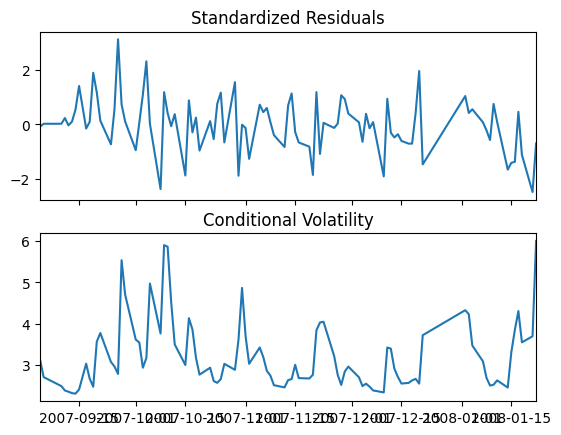

In [15]:
# Создаем модель GARCH(1,1)
# Мы используем доходности (returns), которые вы рассчитали ранее
model_garch = arch_model(train_returns, vol='Garch', p=1, q=1)
results_garch = model_garch.fit(disp='off')

# Показываем таблицу результатов и график волатильности
print(results_garch.summary())
results_garch.plot()
plt.show()

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   TOPL   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -240.125
Distribution:                  Normal   AIC:                           488.249
Method:            Maximum Likelihood   BIC:                           498.423
                                        No. Observations:                   94
Date:                Wed, Jan 14 2026   Df Residuals:                       93
Time:                        17:44:21   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.2407      0.322     -0.748      0.454 [ -0.871,  0.39

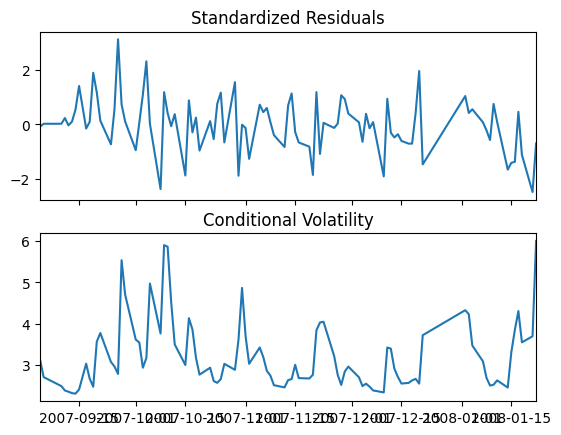

In [16]:
# 1. Обучаем модель GARCH(1,1) для анализа изменчивости (Conditional Variance)
model_garch = arch_model(train_returns, vol='Garch', p=1, q=1)
results_garch = model_garch.fit(disp='off')

# 2. Выводим таблицу параметров (обязательно для презентации)
print(results_garch.summary())

# 3. Строим графики остатков и условной волатильности
results_garch.plot()
plt.show()

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   TOPL   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -240.125
Distribution:                  Normal   AIC:                           488.249
Method:            Maximum Likelihood   BIC:                           498.423
                                        No. Observations:                   94
Date:                Wed, Jan 14 2026   Df Residuals:                       93
Time:                        17:46:28   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.2407      0.322     -0.748      0.454 [ -0.871,  0.39

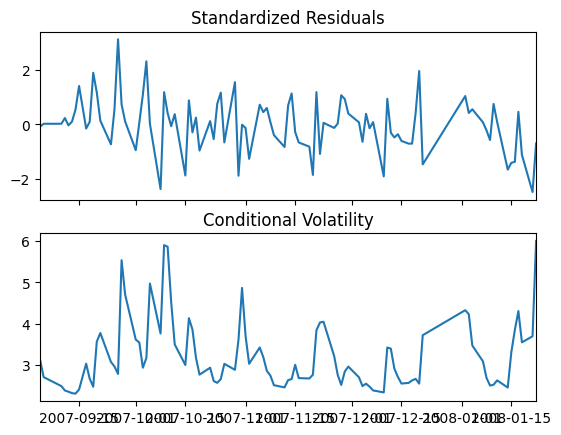

In [17]:
# Финальный шаг для презентации: Модель GARCH
model_final = arch_model(train_returns, vol='Garch', p=1, q=1)
results_final = model_final.fit(disp='off')

# Вывод таблицы с параметрами (alpha и beta)
print(results_final.summary())

# График волатильности (покажет периоды риска)
results_final.plot()
plt.show()